In [80]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from torchvision import datasets
from torchvision.transforms import (
    Compose, ToTensor, Normalize,
    RandomCrop, RandomHorizontalFlip
)

import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm.autonotebook import tqdm as notebook_tqdm

In [81]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [82]:
cifar100_mean = (0.4914, 0.4822, 0.4465)
cifar100_std  = (0.2470, 0.2435, 0.2616)

In [83]:
train_transform = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(cifar100_mean, cifar100_std)
])

test_transform = Compose([
    ToTensor(),
    Normalize(cifar100_mean, cifar100_std)
])

In [84]:
train_data_aug = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transform
)

train_data_plain = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=test_transform
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=test_transform
)

class_names = train_data_aug.classes
print(class_names)

100%|██████████| 170M/170M [00:02<00:00, 81.7MB/s] 


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [85]:
def unnormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean

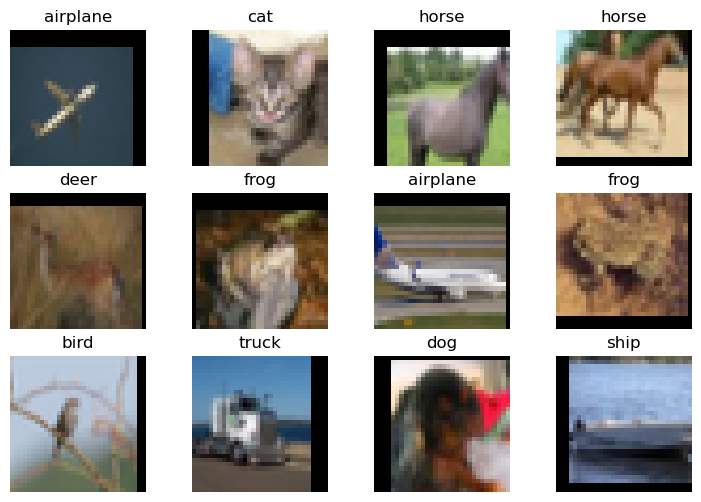

In [86]:
fig = plt.figure(figsize=(9,6))
rows, cols = 3, 4

for i in range(1, rows * cols + 1):
    idx = torch.randint(0, len(train_data_aug), size=(1,)).item()
    img, label = train_data_aug[idx]
    
    img_vis = unnormalize(img, cifar100_mean, cifar100_std).clamp(0,1)
    img_vis = img_vis.permute(1, 2, 0)
    
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img_vis)
    ax.set_title(class_names[label])
    ax.axis("off")

In [87]:
torch.manual_seed(42)

train_size = 45_000
val_size = 50_000 - train_size

indicies = torch.randperm(50_000)
train_indicies = indicies[:train_size].tolist()
val_indicies = indicies[train_size:].tolist()

train_dataset = Subset(train_data_aug, train_indicies)
val_dataset = Subset(train_data_plain, val_indicies)

In [88]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=512,       shuffle=False, num_workers=0)
test_loader  = DataLoader(test_data,     batch_size=256,       shuffle=False, num_workers=0)

In [89]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.25):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.block(x)

In [90]:
class CIFAR100_CNN(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
        )
        
        self.pool = nn.AdaptiveMaxPool2d((1, 1))  # (B, 256, H, W) -> (B, 256, 1, 1)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        logits = self.classifier(x)
        return logits

In [91]:
model = CIFAR100_CNN(num_classes=len(class_names)).to(device)
print(model)

CIFAR100_CNN(
  (features): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Dropout(p=0.25, inplace=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [92]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [93]:
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

In [94]:
@torch.inference_mode()
def eval_one_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        
        logits = model(X)
        loss = loss_fn(logits, y)
        
        batch_size = y.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_examples += batch_size
        
    return total_loss / total_examples, total_correct / total_examples

In [95]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    
    for batch, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)
        
        logits = model(X)
        loss = loss_fn(logits, y)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        batch_size = y.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_examples += batch_size
        
        if batch_size % 200 == 0:
            print(f"{batch * batch_size}/{len(loader.dataset)} samples...")
        
    return total_loss / total_examples, total_correct / total_examples

In [96]:
epochs = 25
best_val_acc = 0.0

start = timer()

for epoch in notebook_tqdm(range(1, epochs + 1)):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_func, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, loss_func, device)
    scheduler.step()
    
    print(
        f"Epoch {epoch:02d} | "
        f"train loss {train_loss:.4f}, train acc {train_acc*100:.2f}% | "
        f"val loss {val_loss:.4f}, val acc {val_acc*100:.2f}% | "
        f"lr {scheduler.get_last_lr()[0]:.6f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "cifar100_cnn_best.pt")
        print(f"  Saved new best model: val acc {best_val_acc*100:.2f}%")

end = timer()
print(f"Training time: {end - start:.2f} seconds on {device}")

  4%|▍         | 1/25 [00:08<03:22,  8.44s/it]

Epoch 01 | train loss 1.5468, train acc 42.56% | val loss 1.1840, val acc 58.30% | lr 0.000976
  Saved new best model: val acc 58.30%


  8%|▊         | 2/25 [00:15<02:51,  7.46s/it]

Epoch 02 | train loss 1.1096, train acc 60.37% | val loss 0.9562, val acc 66.30% | lr 0.000905
  Saved new best model: val acc 66.30%


 12%|█▏        | 3/25 [00:21<02:36,  7.09s/it]

Epoch 03 | train loss 0.9424, train acc 66.56% | val loss 0.8323, val acc 71.50% | lr 0.000794
  Saved new best model: val acc 71.50%


 16%|█▌        | 4/25 [00:28<02:22,  6.79s/it]

Epoch 04 | train loss 0.8348, train acc 70.70% | val loss 0.8006, val acc 73.16% | lr 0.000655
  Saved new best model: val acc 73.16%


 20%|██        | 5/25 [00:34<02:12,  6.60s/it]

Epoch 05 | train loss 0.7592, train acc 73.51% | val loss 0.6418, val acc 78.08% | lr 0.000500
  Saved new best model: val acc 78.08%


 24%|██▍       | 6/25 [00:40<02:03,  6.50s/it]

Epoch 06 | train loss 0.6976, train acc 75.76% | val loss 0.6100, val acc 80.08% | lr 0.000345
  Saved new best model: val acc 80.08%


 28%|██▊       | 7/25 [00:47<01:56,  6.45s/it]

Epoch 07 | train loss 0.6473, train acc 77.63% | val loss 0.5707, val acc 80.76% | lr 0.000206
  Saved new best model: val acc 80.76%


 32%|███▏      | 8/25 [00:53<01:48,  6.41s/it]

Epoch 08 | train loss 0.6111, train acc 78.71% | val loss 0.5465, val acc 81.64% | lr 0.000095
  Saved new best model: val acc 81.64%


 36%|███▌      | 9/25 [00:59<01:41,  6.37s/it]

Epoch 09 | train loss 0.5879, train acc 79.71% | val loss 0.5149, val acc 82.48% | lr 0.000024
  Saved new best model: val acc 82.48%


 40%|████      | 10/25 [01:06<01:35,  6.35s/it]

Epoch 10 | train loss 0.5683, train acc 80.61% | val loss 0.5045, val acc 82.84% | lr 0.000000
  Saved new best model: val acc 82.84%


 44%|████▍     | 11/25 [01:12<01:28,  6.34s/it]

Epoch 11 | train loss 0.5632, train acc 80.50% | val loss 0.5046, val acc 82.90% | lr 0.000024
  Saved new best model: val acc 82.90%


 48%|████▊     | 12/25 [01:18<01:22,  6.34s/it]

Epoch 12 | train loss 0.5606, train acc 80.58% | val loss 0.5040, val acc 82.98% | lr 0.000095
  Saved new best model: val acc 82.98%


 52%|█████▏    | 13/25 [01:24<01:15,  6.32s/it]

Epoch 13 | train loss 0.5673, train acc 80.42% | val loss 0.5078, val acc 82.46% | lr 0.000206


 56%|█████▌    | 14/25 [01:31<01:09,  6.34s/it]

Epoch 14 | train loss 0.5751, train acc 80.14% | val loss 0.5246, val acc 82.26% | lr 0.000345


 60%|██████    | 15/25 [01:37<01:03,  6.32s/it]

Epoch 15 | train loss 0.5889, train acc 79.76% | val loss 0.5260, val acc 82.48% | lr 0.000500


 64%|██████▍   | 16/25 [01:43<00:56,  6.31s/it]

Epoch 16 | train loss 0.5982, train acc 79.50% | val loss 0.5437, val acc 81.74% | lr 0.000655


 68%|██████▊   | 17/25 [01:50<00:50,  6.30s/it]

Epoch 17 | train loss 0.6083, train acc 79.10% | val loss 0.5570, val acc 81.48% | lr 0.000794


 72%|███████▏  | 18/25 [01:56<00:44,  6.30s/it]

Epoch 18 | train loss 0.6073, train acc 79.24% | val loss 0.5184, val acc 82.84% | lr 0.000905


 76%|███████▌  | 19/25 [02:03<00:38,  6.41s/it]

Epoch 19 | train loss 0.6010, train acc 79.34% | val loss 0.5155, val acc 82.34% | lr 0.000976


 80%|████████  | 20/25 [02:09<00:32,  6.50s/it]

Epoch 20 | train loss 0.5935, train acc 79.73% | val loss 0.5435, val acc 81.64% | lr 0.001000


 84%|████████▍ | 21/25 [02:16<00:26,  6.55s/it]

Epoch 21 | train loss 0.5738, train acc 80.30% | val loss 0.5472, val acc 81.70% | lr 0.000976


 88%|████████▊ | 22/25 [02:23<00:19,  6.59s/it]

Epoch 22 | train loss 0.5574, train acc 80.78% | val loss 0.4559, val acc 84.70% | lr 0.000905
  Saved new best model: val acc 84.70%


 92%|█████████▏| 23/25 [02:29<00:13,  6.63s/it]

Epoch 23 | train loss 0.5349, train acc 81.66% | val loss 0.4873, val acc 83.30% | lr 0.000794


 96%|█████████▌| 24/25 [02:36<00:06,  6.65s/it]

Epoch 24 | train loss 0.5185, train acc 82.31% | val loss 0.4495, val acc 84.10% | lr 0.000655


100%|██████████| 25/25 [02:43<00:00,  6.53s/it]

Epoch 25 | train loss 0.4868, train acc 83.30% | val loss 0.4080, val acc 85.96% | lr 0.000500
  Saved new best model: val acc 85.96%
Training time: 163.34 seconds on cuda


In [97]:
model.load_state_dict(torch.load("cifar100_cnn_best.pt", map_location=device))
model = model.to(device)
test_loss, test_acc = eval_one_epoch(model, test_loader, loss_func, device)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc*100:.2f}%")

Test loss: 0.4316 | Test acc: 85.46%


In [ ]:
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X = X.to(device)
        logits = model(X)
        preds = logits.argmax(dim=1).cpu()
        all_preds.append(preds)
        all_labels.append(y)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

correct = (all_preds == all_labels)
print(f"Overall test accuracy: {correct.float().mean().item()*100:.2f}%")
print(f"Total test samples: {len(all_labels)}")

Overall test accuracy: 85.46%
Total test samples: 10000


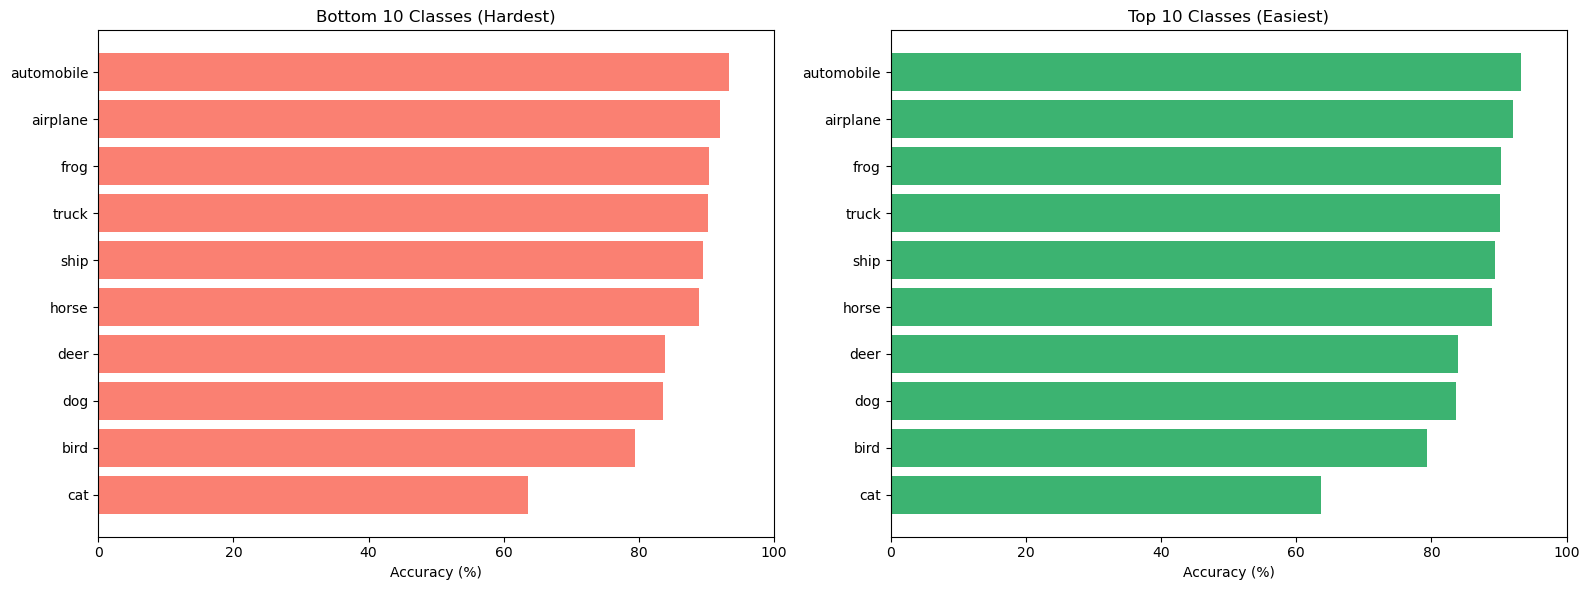

In [ ]:
# Per-class accuracy for top and bottom 10 classes
per_class_correct = torch.zeros(len(class_names))
per_class_total = torch.zeros(len(class_names))

for p, t in zip(all_preds, all_labels):
    per_class_total[t] += 1
    if p == t:
        per_class_correct[t] += 1

per_class_acc = (per_class_correct / per_class_total * 100).numpy()
sorted_idx = np.argsort(per_class_acc)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bottom 10 hardest classes
bot10 = sorted_idx[:10]
axes[0].barh([class_names[i] for i in bot10], per_class_acc[bot10], color="salmon")
axes[0].set_xlabel("Accuracy (%)")
axes[0].set_title("Bottom 10 Classes (Hardest)")
axes[0].set_xlim(0, 100)

# Top 10 easiest classes
top10 = sorted_idx[-10:]
axes[1].barh([class_names[i] for i in top10], per_class_acc[top10], color="mediumseagreen")
axes[1].set_xlabel("Accuracy (%)")
axes[1].set_title("Top 10 Classes (Easiest)")
axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.show()

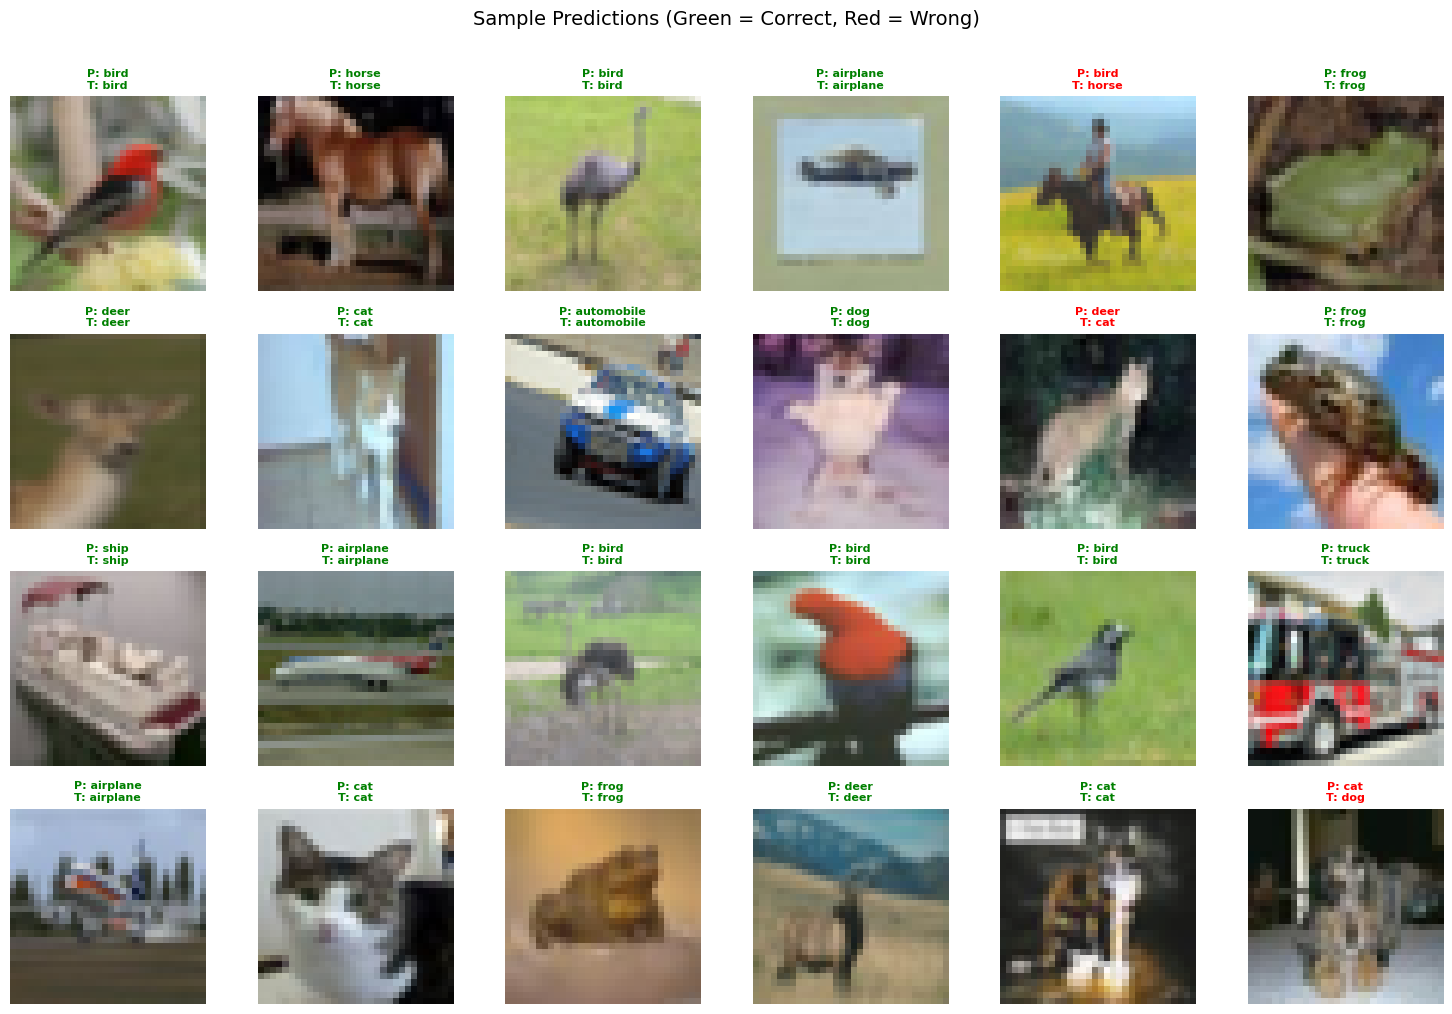

In [ ]:
# Sample predictions grid
# Green = correct, red = incorrect

fig, axes = plt.subplots(4, 6, figsize=(15, 10))
sample_idx = torch.randperm(len(test_data))[:24]

for i, ax in enumerate(axes.flat):
    idx = sample_idx[i].item()
    img, true_label = test_data[idx]
    pred_label = all_preds[idx].item()

    img_vis = unnormalize(img, cifar100_mean, cifar100_std).clamp(0, 1)
    img_vis = img_vis.permute(1, 2, 0)

    ax.imshow(img_vis)
    is_correct = pred_label == true_label
    color = "green" if is_correct else "red"
    ax.set_title(
        f"P: {class_names[pred_label]}\nT: {class_names[true_label]}",
        fontsize=8, color=color, fontweight="bold"
    )
    ax.axis("off")

fig.suptitle("Sample Predictions (Green = Correct, Red = Wrong)", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

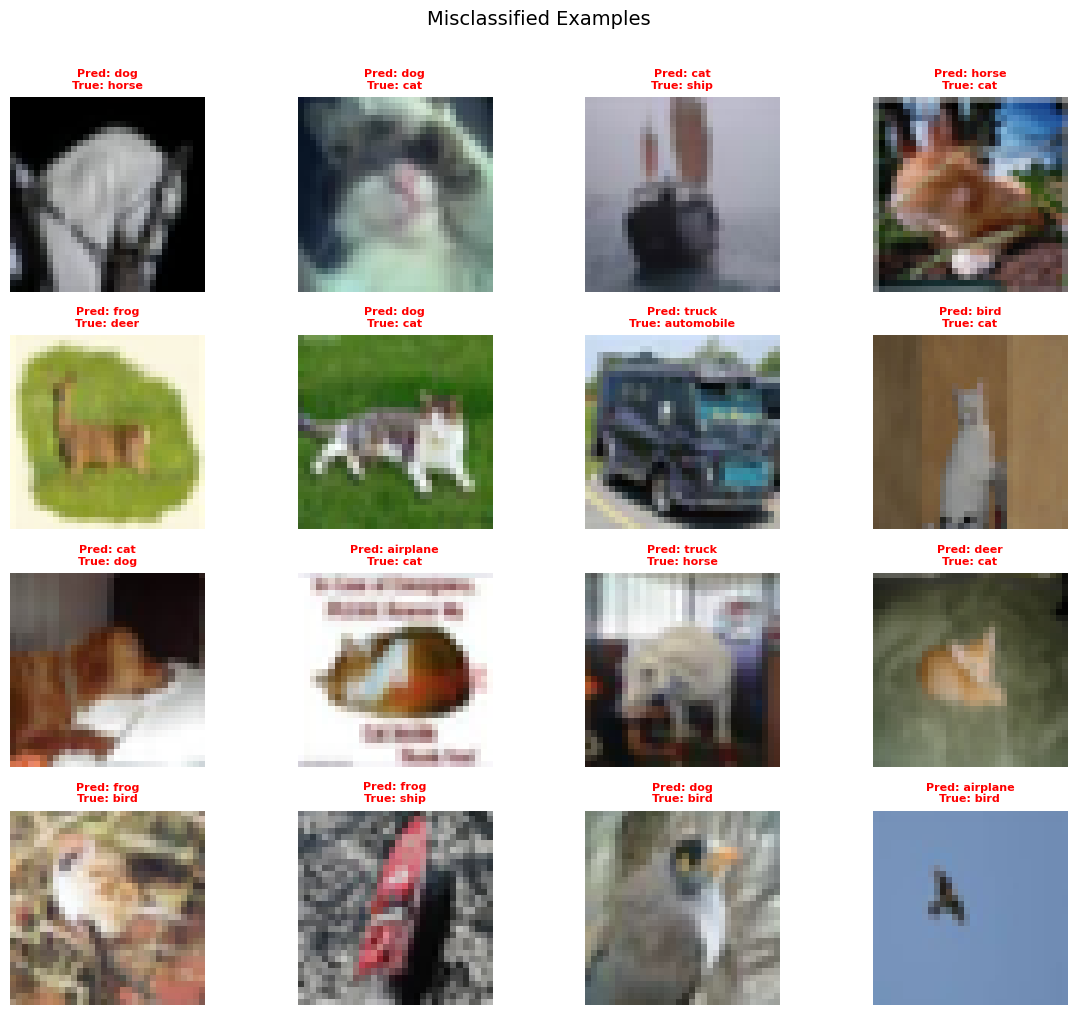

In [ ]:
# Misclassified examples
wrong_mask = (all_preds != all_labels)
wrong_indices = torch.where(wrong_mask)[0]
sample_wrong = wrong_indices[torch.randperm(len(wrong_indices))[:16]]

fig, axes = plt.subplots(4, 4, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    idx = sample_wrong[i].item()
    img, true_label = test_data[idx]
    pred_label = all_preds[idx].item()

    img_vis = unnormalize(img, cifar100_mean, cifar100_std).clamp(0, 1)
    img_vis = img_vis.permute(1, 2, 0)

    ax.imshow(img_vis)
    ax.set_title(
        f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
        fontsize=8, color="red", fontweight="bold"
    )
    ax.axis("off")

fig.suptitle("Misclassified Examples", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

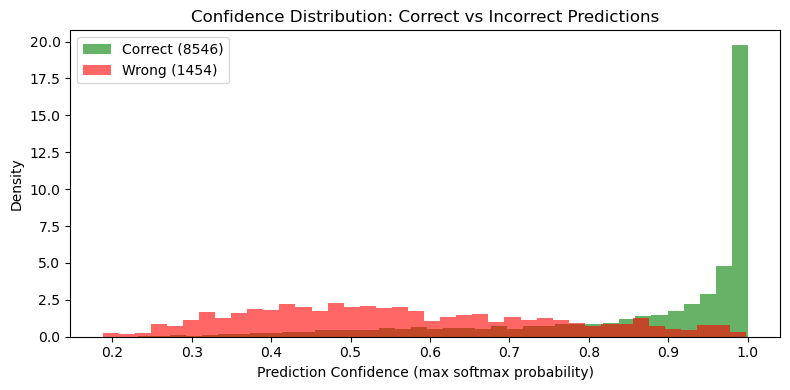

In [ ]:
# Confidence distribution
# Compares correct vs incorrect predictions
# Lets you kind of see the ovelap and how it corresponds to the models accuracy

model.eval()
all_probs = []
with torch.inference_mode():
    for X, y in test_loader:
        X = X.to(device)
        logits = model(X)
        probs = torch.softmax(logits, dim=1).cpu()
        all_probs.append(probs)

all_probs = torch.cat(all_probs)
max_conf = all_probs.max(dim=1).values.numpy()

correct_conf = max_conf[correct.numpy()]
wrong_conf = max_conf[~correct.numpy()]

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(correct_conf, bins=40, alpha=0.6, label=f"Correct ({len(correct_conf)})", color="green", density=True)
ax.hist(wrong_conf, bins=40, alpha=0.6, label=f"Wrong ({len(wrong_conf)})", color="red", density=True)
ax.set_xlabel("Prediction Confidence (max softmax probability)")
ax.set_ylabel("Density")
ax.set_title("Confidence Distribution: Correct vs Incorrect Predictions")
ax.legend()
plt.tight_layout()
plt.show()